In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import zipfile
import io
import warnings
warnings.filterwarnings("ignore")

In [20]:
BASE_URL = "http://oasis.caiso.com/oasisapi/SingleZip"

def fetch_caiso_data(queryname, start, end, extra_params=None):
    params = {
        "queryname": queryname,
        "startdatetime": start,
        "enddatetime": end,
        "version": "1",
        "resultformat": "6"  # CSV
    }

    if extra_params:
        params.update(extra_params)

    response = requests.get(BASE_URL, params=params)
    response.raise_for_status()

    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        csv_files = [name for name in z.namelist() if name.endswith('.csv')]
        if not csv_files:
            print(f"⚠️ No CSV files found in the ZIP for query: {queryname}")
            return pd.DataFrame()
        df = pd.read_csv(z.open(csv_files[0]))
    return df

# Date range
start = "20250601T07:00-0000"
end   = "20250701T07:00-0000"

# Forecasted Load (Day-Ahead Market)
forecast_df = fetch_caiso_data("SLD_FCST", start, end, {"market_run_id": "DAM"})

# Actual Load (Real-Time Market)
actual_df = fetch_caiso_data("SLD_FCST", start, end, {"market_run_id": "RTM"})

In [21]:
forecast_df.head()

,INTERVALSTARTTIME_GMT,INTERVALENDTIME_GMT,LOAD_TYPE,OPR_DT,OPR_HR,OPR_INTERVAL,MARKET_RUN_ID,TAC_AREA_NAME,LABEL,XML_DATA_ITEM,POS,MW,EXECUTION_TYPE,GROUP
0,2025-06-01T13:00:00-00:00,2025-06-01T14:00:00-00:00,1,2025-06-01,7,0,DAM,AVA,Demand Forecast Day Ahead,SYS_FCST_DA_MW,2.8,890.93,DAM,1
1,2025-06-02T02:00:00-00:00,2025-06-02T03:00:00-00:00,1,2025-06-01,20,0,DAM,AVA,Demand Forecast Day Ahead,SYS_FCST_DA_MW,2.8,1129.39,DAM,1
2,2025-06-01T07:00:00-00:00,2025-06-01T08:00:00-00:00,1,2025-06-01,1,0,DAM,AVA,Demand Forecast Day Ahead,SYS_FCST_DA_MW,2.8,921.66,DAM,1
3,2025-06-01T14:00:00-00:00,2025-06-01T15:00:00-00:00,1,2025-06-01,8,0,DAM,AVA,Demand Forecast Day Ahead,SYS_FCST_DA_MW,2.8,950.06,DAM,1
4,2025-06-01T19:00:00-00:00,2025-06-01T20:00:00-00:00,1,2025-06-01,13,0,DAM,AVA,Demand Forecast Day Ahead,SYS_FCST_DA_MW,2.8,1090.45,DAM,1


In [22]:
# Step 1: Filter for system-wide total (PGE-TAC only)
forecast_df_filtered = forecast_df[forecast_df["TAC_AREA_NAME"] == "PGE-TAC"]
actual_df_filtered = actual_df[actual_df["TAC_AREA_NAME"] == "PGE-TAC"]

# Step 2: Group by date and hour, take the average MW for each hour
forecast_hourly = forecast_df_filtered.groupby(["OPR_DT", "OPR_HR"])["MW"].mean().reset_index()
actual_hourly = actual_df_filtered.groupby(["OPR_DT", "OPR_HR"])["MW"].mean().reset_index()

# Step 3: Merge the two DataFrames on date and hour
merged_df = pd.merge(forecast_hourly, actual_hourly, on=["OPR_DT", "OPR_HR"], suffixes=('_forecast', '_actual'))

# Step 4: Calculate error metrics
merged_df["abs_error"] = (merged_df["MW_forecast"] - merged_df["MW_actual"]).abs()
merged_df["percent_error"] = (merged_df["abs_error"] / merged_df["MW_actual"]) * 100

# Optional: Preview
print(merged_df.head())

       OPR_DT  OPR_HR  MW_forecast     MW_actual    abs_error  percent_error
0  2025-06-01       1     12169.38  11171.940625   997.439375       8.928076
1  2025-06-01       2     11445.98  10456.363125   989.616875       9.464255
2  2025-06-01       3     10899.68   9834.796250  1064.883750      10.827715
3  2025-06-01       4     10511.01   9429.905000  1081.105000      11.464644
4  2025-06-01       5     10249.46   9183.235625  1066.224375      11.610552


In [23]:
from sklearn.ensemble import IsolationForest

# Use only percent_error (or include hour, forecast, etc.)
features = merged_df[["percent_error"]]
clf = IsolationForest(contamination=0.05, random_state=42)
merged_df["anomaly_iforest"] = clf.fit_predict(features)  # -1 = anomaly

# Convert to boolean
merged_df["is_anomaly"] = merged_df["anomaly_iforest"] == -1

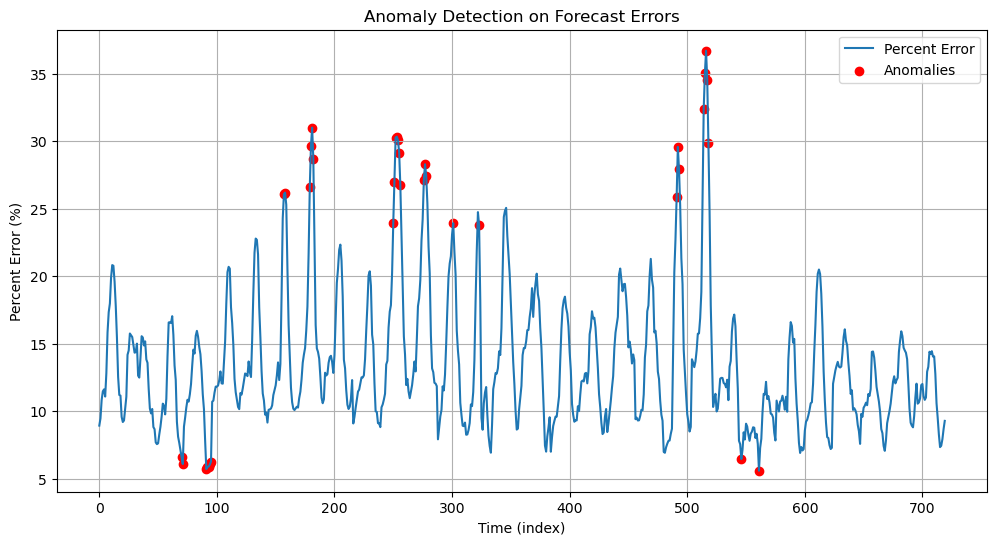

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(merged_df["percent_error"].values, label="Percent Error")
plt.scatter(merged_df.index[merged_df["is_anomaly"]],
            merged_df["percent_error"][merged_df["is_anomaly"]],
            color='red', label="Anomalies")
plt.legend()
plt.title("Anomaly Detection on Forecast Errors")
plt.xlabel("Time (index)")
plt.ylabel("Percent Error (%)")
plt.grid(True)
plt.show()


In [25]:
merged_df["forecast_bias"] = merged_df["MW_forecast"] - merged_df["MW_actual"]
merged_df["hour"] = merged_df["OPR_HR"]
merged_df["day_of_week"] = pd.to_datetime(merged_df["OPR_DT"]).dt.dayofweek
merged_df["is_peak_hour"] = merged_df["hour"].between(16, 21).astype(int)  # 4 PM to 9 PM
merged_df["rolling_mean_error"] = merged_df["percent_error"].rolling(3).mean()
merged_df["rolling_std_error"] = merged_df["percent_error"].rolling(3).std()

In [26]:
features = merged_df[[
    "percent_error", 
    "forecast_bias", 
    "hour", 
    "day_of_week", 
    "is_peak_hour", 
    "rolling_mean_error", 
    "rolling_std_error"
]].dropna()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
features["cluster"] = kmeans.fit_predict(X_scaled)

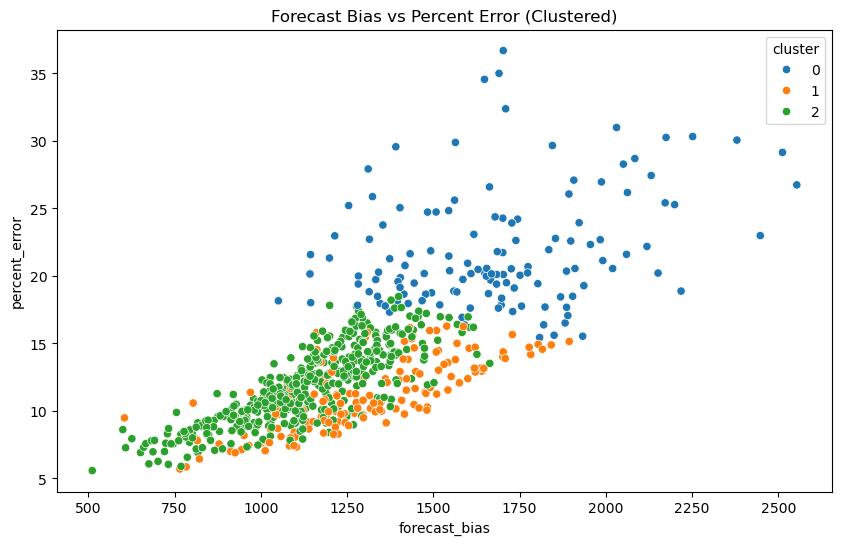

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=features["forecast_bias"],
    y=features["percent_error"],
    hue=features["cluster"],
    palette="tab10"
)
plt.title("Forecast Bias vs Percent Error (Clustered)")
plt.show()


In [29]:
cluster_summary = features.groupby("cluster").agg({
    "forecast_bias": ["mean", "std"],
    "percent_error": ["mean", "std"],
    "hour": "mean",
    "day_of_week": "mean"
})
print(cluster_summary)


        forecast_bias             percent_error                 hour  \
                 mean         std          mean       std       mean   
cluster                                                                
0         1681.679882  298.270476     21.856990  4.295642  13.416667   
1         1300.480025  244.731888     11.244119  2.588120  18.780000   
2         1128.828417  200.578742     11.801668  2.715174  10.112385   

        day_of_week  
               mean  
cluster              
0          3.674242  
1          2.900000  
2          2.816514  


In [30]:
cluster_summary

forecast_bias             percent_error                 hour  \
                 mean         std          mean       std       mean   
cluster                                                                
0         1681.679882  298.270476     21.856990  4.295642  13.416667   
1         1300.480025  244.731888     11.244119  2.588120  18.780000   
2         1128.828417  200.578742     11.801668  2.715174  10.112385   

        day_of_week  
               mean  
cluster              
0          3.674242  
1          2.900000  
2          2.816514

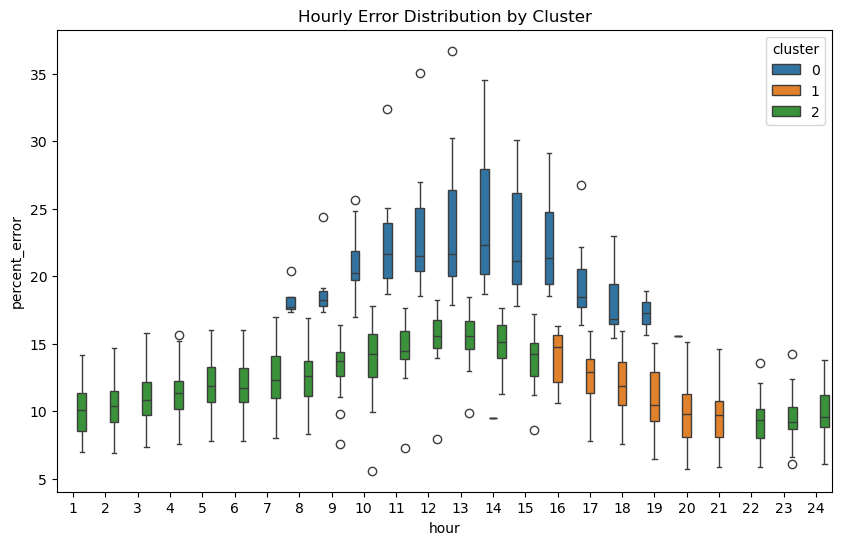

In [31]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x=features["hour"], y=features["percent_error"], hue=features["cluster"], palette="tab10")
plt.title("Hourly Error Distribution by Cluster")
plt.show()
